In [1]:
#import modules
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from sklearn.metrics import precision_score,accuracy_score
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
#import datafiles
#look at the feature extraction technique with the best test accuracy
# kmer

In [3]:
seq_file = '../data/enz_sequence.csv'
label_file = '../data/enz_labels.csv'

In [4]:
df1 = pd.read_csv(seq_file,header=None)
df2 = pd.read_csv(label_file,header=None)
df = df1.merge(df2,on=0)

In [5]:
def filter_by_len(seq):
    val = len(seq)
    if val>200 and val<600:
        return True
    return False

In [6]:
df = df.loc[df['1_x'].apply(filter_by_len)]

In [7]:
# create a smaller test-train
df_0 = df.loc[df.iloc[:,-1]==0]
df_1 = df.loc[df.iloc[:,-1]==1]

In [8]:
train_df0 = df_0.sample(n=int(0.75*(len(df_0))),random_state=42)
valid_df0 = df_0.loc[~df_0.isin(train_df0)[0]]

In [9]:
train_df1 = df_1.sample(n=int(0.6*(len(df_1))),random_state=42)
valid_df1 = df_1.loc[~df_1.isin(train_df1)[0]]

In [10]:
train_df = pd.concat([train_df0,train_df1])
valid_df = pd.concat([valid_df0,valid_df1])

In [11]:
train_df = train_df.sample(frac=1,random_state=42)

In [12]:
valid_df = valid_df.sample(frac=1,random_state=42)

In [14]:
#define data
testenz_names = valid_df.iloc[:,0].values
X_test = valid_df.iloc[:,1].values
y_test = valid_df.iloc[:,-1].values

In [15]:
#define data
enz_names = train_df.iloc[:,0].values
X = train_df.iloc[:,1].values
y = train_df.iloc[:,-1].values

In [16]:
np.unique(y,return_counts=True)

(array([0, 1]), array([1248, 1685]))

In [99]:
# train test split
X_train, X_valid, y_train, y_valid, enz_train, enz_test = train_test_split(X, y, enz_names, 
                        test_size=0.1, random_state=42)

In [100]:
import sys
sys.path.append('../')

In [101]:
from featEngg.online.kmerMethods.models import ngModel

In [102]:
ng = ngModel(X_train,X_valid,X_test,k=3,s=1,inc_count=True)

In [103]:
X_train,X_valid,X_test = ng.Xtrain,ng.Xvalid,ng.Xtest

In [104]:
def dt_clf(max_depth):
    dt = DecisionTreeClassifier(max_features='auto',
                                max_depth=max_depth,random_state=42)
    
    steps = [('pca',PCA(n_components=150)),('dt',dt)]
    pipe = Pipeline(steps)
    pipe.fit(X_train,y_train)
    return pipe.score(X_valid,y_valid)

In [105]:
pool = mp.Pool(mp.cpu_count())
depths = [21,55,65,75,90,120,240]
scrs = list(pool.map(dt_clf,depths))

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

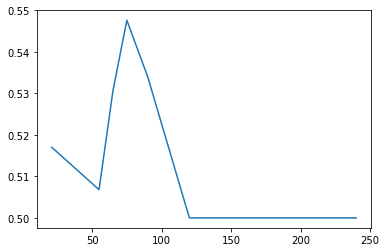

In [107]:
plt.plot(depths,scrs)

In [108]:
max(scrs)

0.5476190476190477

In [109]:
def get_dtclf(max_depth):
    dt = DecisionTreeClassifier(max_features='auto',
                                max_depth=max_depth,random_state=42)
    steps = [('pca',PCA(n_components=150)),('dt',dt)]
    pipe = Pipeline(steps)
    pipe.fit(X_train,y_train)
    return pipe

In [112]:
dtree= get_dtclf(75)
yhat_valid = dtree.predict(X_valid)

In [113]:
accuracy_score(y_valid,yhat_valid),precision_score(y_valid,yhat_valid,pos_label=0)

(0.5476190476190477, 0.5217391304347826)

In [114]:
yhat_test = dtree.predict(X_test)

In [115]:
accuracy_score(y_test,yhat_test),precision_score(y_test,yhat_test,pos_label=0)

(0.5314730694354315, 0.2884882108183079)

In [116]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([ 417, 1124]))

In [117]:
np.unique(yhat_test,return_counts=True)

(array([0, 1]), array([721, 820]))

In [118]:
precision_score(y_test,yhat_test,pos_label=1)

0.7451219512195122

In [227]:
skbest = SelectKBest(f_classif, k=485)
X_tr_best = skbest.fit_transform(X_train,y_train)
X_va_best = skbest.transform(X_valid)

In [291]:
# NN
def nn_clf(hl):
    nn = MLPClassifier(hidden_layer_sizes = hl,
                        alpha= 0.75,
                        random_state=42,
                        learning_rate='adaptive',
                        learning_rate_init=0.01,
                      max_iter=1000,
                      early_stopping=False)
    steps = [('pca',PCA(n_components=150)),('nn',nn)]
    pipe = Pipeline(steps)
    pipe.fit(X_tr_best,y_train)
    return pipe.score(X_va_best,y_valid)

In [292]:
pool = mp.Pool(mp.cpu_count())
hls = [(10,),(50,),(100,),(125,),(135,),(150,),(250,),(350,),(375,),
      (10,5,),(100,50,),(125,75,),(350,150,),
      (100,75,50,25,15,),(125,95,70,35,5)]
scrs_nn = list(pool.map(nn_clf,hls))

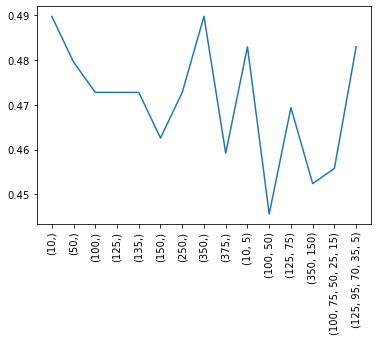

In [293]:
plt.plot(scrs_nn)
plt.xticks(range(len(hls)),hls,rotation=90);

In [294]:
max(scrs_nn)

0.4897959183673469

In [315]:
def get_nnclf(hl):
    nn = MLPClassifier(hidden_layer_sizes = hl,
                        alpha= 0.25,
                        random_state=42,
                        learning_rate='adaptive',
                        learning_rate_init=0.01,
                      max_iter=1000,
                      early_stopping=False)
    steps = [('pca',PCA(n_components=250)),('nn',nn)]
    pipe = Pipeline(steps)
    pipe.fit(X_tr_best,y_train)
    return pipe

In [316]:
nn_clf = get_nnclf((100,))

In [317]:
yhat_valid = nn_clf.predict(X_va_best)

In [318]:
yhat_train = nn_clf.predict(X_tr_best)

In [319]:
accuracy_score(y_train,yhat_train)

0.9814323607427056

In [320]:
accuracy_score(y_valid,yhat_valid),precision_score(y_valid,yhat_valid,pos_label=0)

(0.5170068027210885, 0.4857142857142857)

In [321]:
precision_score(y_valid,yhat_valid,pos_label=1)

0.5343915343915344

In [322]:
X_te_best = skbest.transform(X_test)

In [323]:
yhat_test = nn_clf.predict(X_te_best)

In [324]:
accuracy_score(y_test,yhat_test),precision_score(y_test,yhat_test,pos_label=0)

(0.5717066839714471, 0.2849557522123894)

In [325]:
precision_score(y_test,yhat_test,pos_label=1)

0.7377049180327869

In [326]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([ 417, 1124]))

In [327]:
np.unique(yhat_test,return_counts=True)

(array([0, 1]), array([565, 976]))

In [224]:
tp = 0
fp = 0
for i,j in zip(yhat_test,y_test):
    if i==j==1:
        tp+=1
    if i==1 and j!=1:
        fp+=1

In [225]:
tp/(tp+fp)

0.7437923250564334

In [226]:
tp,fp

(659, 227)

In [204]:
precision_score(y_valid,nn_clf.predict(X_va_best),pos_label=0)

0.43373493975903615